# Working - Foster Care Analysis
This file is a working document for the Foster Care Analysis project. This is not the final version of the project. The final version will be published in a separate file.

In [1]:
# import the necessary packages

from google.cloud import storage
import pandas as pd
import numpy as np
# show all columns
pd.set_option('display.max_columns', None)

from dotenv import load_dotenv
import os

In [2]:
# import function files and environment variables
import utils

# Load the .env file
load_dotenv()

# Connect to the Google Cloud Storage bucket
service_account_path = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
client = storage.Client.from_service_account_json(service_account_path)
bucket_name = 'foster-care'
bucket = client.get_bucket(bucket_name)

In [3]:
# reload th imports
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/sophiechance/Documents/Cal/Github/foster_care_analysis/utils.py'>

## Read Data

In [4]:
# Read in Variable Values and Variable Definitions
variable_values_df = pd.read_excel(utils.read_cloud_data(bucket, 'FC Variable Values.xlsx')) # Mapping
variables_df = pd.read_excel(utils.read_cloud_data(bucket, 'FC Variables.xlsx')) # Variable Definitions

In [5]:
# Read in the raw data
raw_df_2001 = pd.read_sas(utils.read_cloud_data(bucket, '2001.sas7bdat'), format='sas7bdat') 
# raw_df_2002 = pd.read_csv(utils.read_cloud_data(bucket, '2002.tab'), sep='\t', lineterminator='\n')
# raw_df_2003 = pd.read_sas(utils.read_cloud_data(bucket, '2003.sas7bdat'), format='sas7bdat') 

In [6]:
df_2001 = utils.make_readable(raw_df_2001, variable_values_df)
# df_2002 = utils.make_readable(raw_df_2002.rename({'FY':'DataYear', 'FIPSCode':'FIPSCODE'}, axis=1), variable_values_df)
# df_2003 = utils.make_readable(raw_df_2003.rename({'FY':'DataYear', 'FIPSCode':'FIPSCODE'}, axis=1), variable_values_df)

# Filter and Clean Data

In [7]:
# all_records = pd.concat([df_2001, df_2002, df_2003], axis=0)
all_records = df_2001.reset_index(drop=True) # temporarily doing 2001 only so that the code runs faster
all_records = utils.remove_nan_values(all_records)

Age Unknown: 0

Total Null Values: 2
Total Records: 813138
Total Columns: 61


In [8]:
all_records.notnull().sum()

DataYear               813138
RecNumbr               813136
MR                     813138
VISHEAR                813138
PHYDIS                 813138
                        ...  
dischargeReason        813138
raceEthnicity          813138
everAdopted            813138
diagnosedDisability    813138
age2021                813138
Length: 61, dtype: int64

In [9]:
# keep only the cases where the child has exited foster care
exited_df = all_records[all_records['Exited'] == 1]
print(exited_df.shape)

(268761, 61)


In [10]:
# Create Binary label for if they have reunified
exited_df['reunified'] = 0
exited_df.loc[(exited_df['Exited'] == 1) & (exited_df['dischargeReason'] == 'Reunified with parent, primary caretaker'), 'reunified'] = 1

/var/folders/x4/dl28z_rx30n4bp144tvcf38m0000gn/T/ipykernel_60722/186036490.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exited_df['reunified'] = 0


# Baseline Model
## Everyone Reunifies

In [11]:
# Check to make sure the split is even
print(f"Reunified: {exited_df.reunified.value_counts()[0]}")
print(f"Not Reunified: {exited_df.reunified.value_counts()[1]}")
perc_reunified = exited_df.reunified.value_counts()[1] / exited_df.reunified.value_counts().sum()
print(f"\nPercentage Reunified: {round(perc_reunified*100, 2)}%")

Reunified: 120226
Not Reunified: 148535

Percentage Reunified: 55.27%


# Visualizing the data

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
chart_df = exited_df[exited_df['AgeAtEnd'] <= 21]

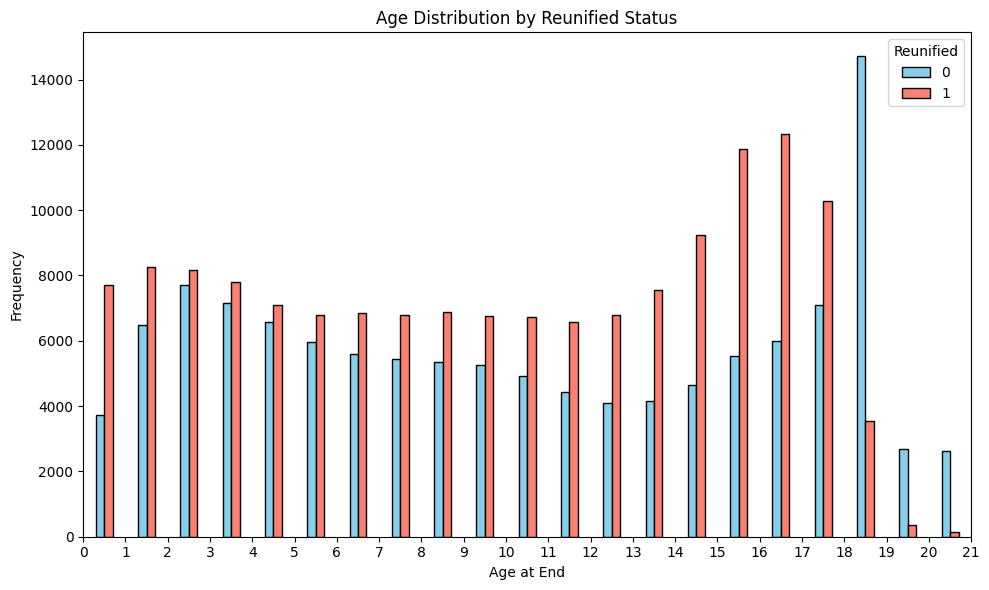

In [14]:
# Filter the DataFrame for each category in 'reunified'
group1 = chart_df[chart_df['reunified'] == chart_df['reunified'].unique()[0]]['AgeAtEnd']
group2 = chart_df[chart_df['reunified'] == chart_df['reunified'].unique()[1]]['AgeAtEnd']

plt.figure(figsize=(10, 6))

# Set the positions of the bars
bins = np.histogram_bin_edges(chart_df['AgeAtEnd'], bins=21)
width = (bins[1] - bins[0]) * 0.4

plt.hist([group1, group2], bins=bins, label=[str(chart_df['reunified'].unique()[0]), str(chart_df['reunified'].unique()[1])], 
         color=['skyblue', 'salmon'], edgecolor='black',  rwidth=width, align='mid', histtype='bar')

plt.legend(title='Reunified')
plt.xlabel('Age at End')
plt.ylabel('Frequency')
plt.title('Age Distribution by Reunified Status')

plt.xticks(bins.round(2))
plt.xlim([bins.min(), bins.max()])  
plt.tight_layout()
plt.show()


Text(0, 0.5, '% Reunified')

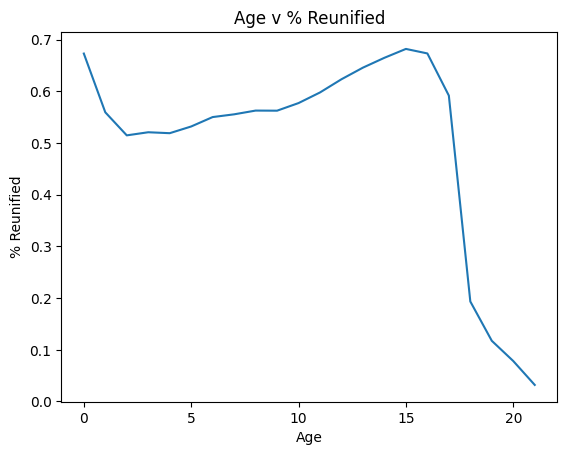

In [15]:
# plot age v % that reunified
age_reunified = chart_df.groupby('AgeAtEnd')['reunified'].mean()
age_reunified.plot()
plt.title('Age v % Reunified')
plt.xlabel('Age')
plt.ylabel('% Reunified')

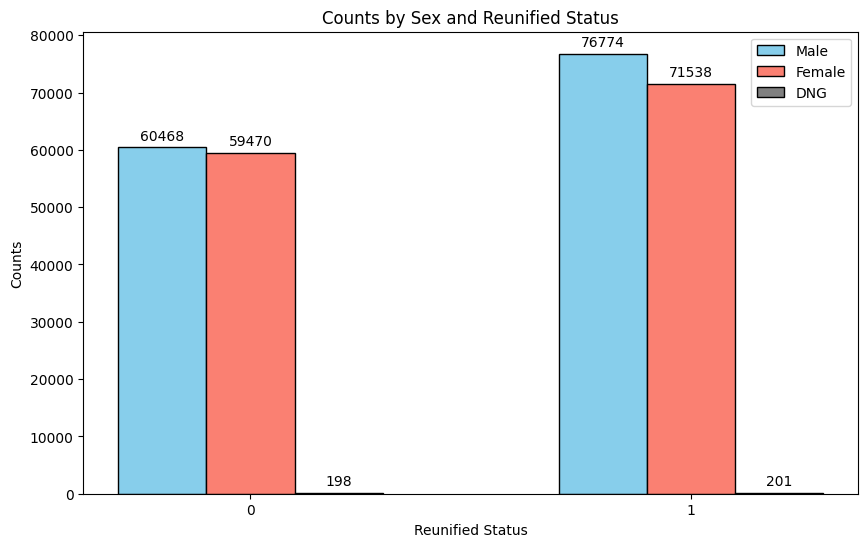

In [16]:
count_matrix = chart_df.groupby(['reunified', 'Sex']).size().unstack()
fig, ax = plt.subplots(figsize=(10, 6))
ind = np.arange(len(count_matrix))
width = 0.2 # the width of the bars

# Plotting the bars
bars1 = ax.bar(ind - width, count_matrix['Male'], width, label='Male', color='skyblue', edgecolor='black')
bars2 = ax.bar(ind, count_matrix['Female'], width, label='Female', color='salmon', edgecolor='black')
bars3 = ax.bar(ind + width, count_matrix['DNG'], width, label='DNG', color='grey', edgecolor='black')

ax.set_xlabel('Reunified Status')
ax.set_ylabel('Counts')
ax.set_title('Counts by Sex and Reunified Status')
ax.set_xticks(ind)
ax.set_xticklabels(count_matrix.index)
ax.legend()

ax.bar_label(bars1, padding=3)
ax.bar_label(bars2, padding=3)
ax.bar_label(bars3, padding=3)

plt.show()


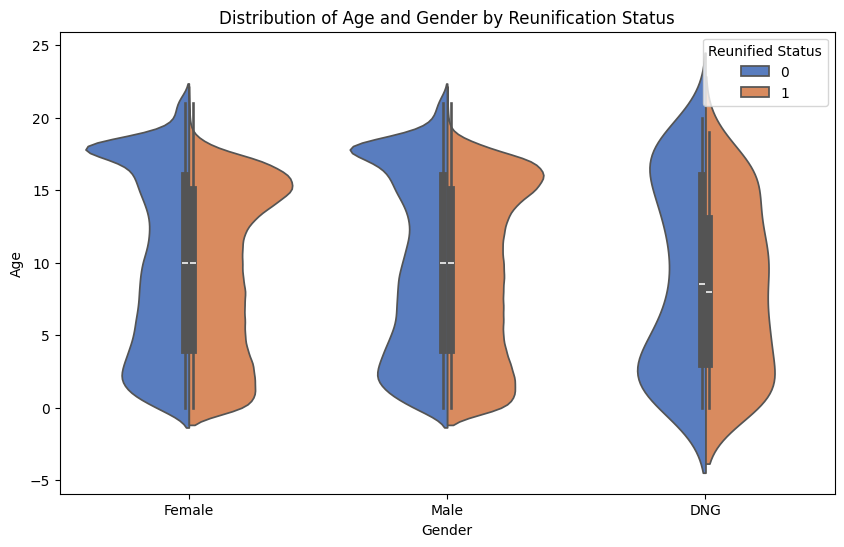

In [17]:
plt.figure(figsize=(10, 6))
sns.violinplot(x="Sex", y="AgeAtEnd", hue="reunified", data=chart_df, palette="muted", split=True)

plt.title('Distribution of Age and Gender by Reunification Status')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.legend(title='Reunified Status')

plt.show()

# Creating Dataset for Model

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
ml_data_df = exited_df.drop(['DataYear', 'RecNumbr', 'dischargeReason', 'age2021', 'caseGoal', 'AgeAtStart', 'AgedOut'], axis=1)

In [20]:
ml_df = pd.get_dummies(ml_data_df, columns=['State', 'FIPSCode', 'Sex', 'removalManner', 'currentPlacementSetting', 'caretakerFamilyStructure', 'fosterFamilyStructure',  'raceEthnicity', 'diagnosedDisability', 'AgeAdopt', 'everAdopted', 'OutOfStatePlacement']) #'caseGoal',

In [21]:
X = ml_df.drop('reunified', axis=1)  # Features
y = ml_df['reunified']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
# Initialize the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [24]:
from sklearn.metrics import accuracy_score, classification_report

# Predictions
y_pred = rf.predict(X_test)

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.8646029058843228
              precision    recall  f1-score   support

           0       0.89      0.80      0.84     23946
           1       0.85      0.92      0.88     29807

    accuracy                           0.86     53753
   macro avg       0.87      0.86      0.86     53753
weighted avg       0.87      0.86      0.86     53753



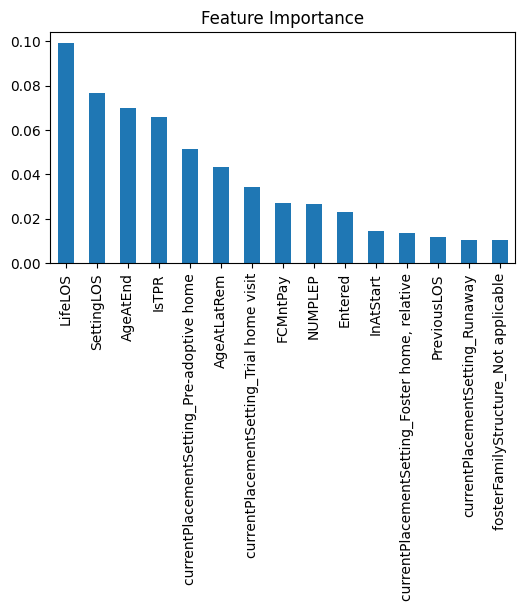

In [25]:
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances[:15].plot(kind='bar', figsize=(6, 3))
plt.title('Feature Importance')
plt.show()


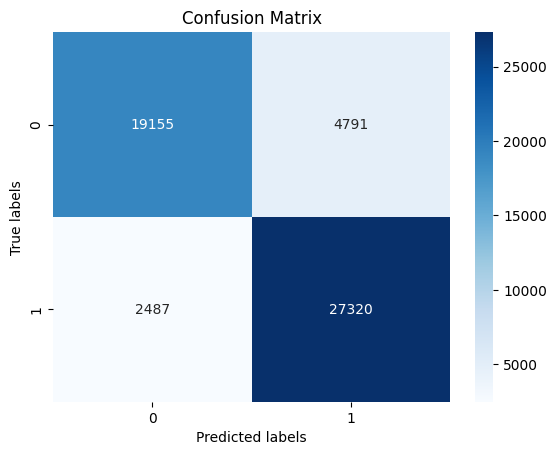

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

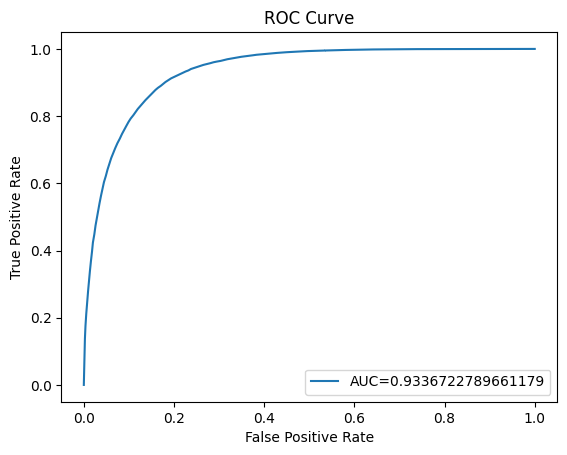

In [27]:
from sklearn.metrics import roc_curve, auc

y_pred_proba = rf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = auc(fpr, tpr)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

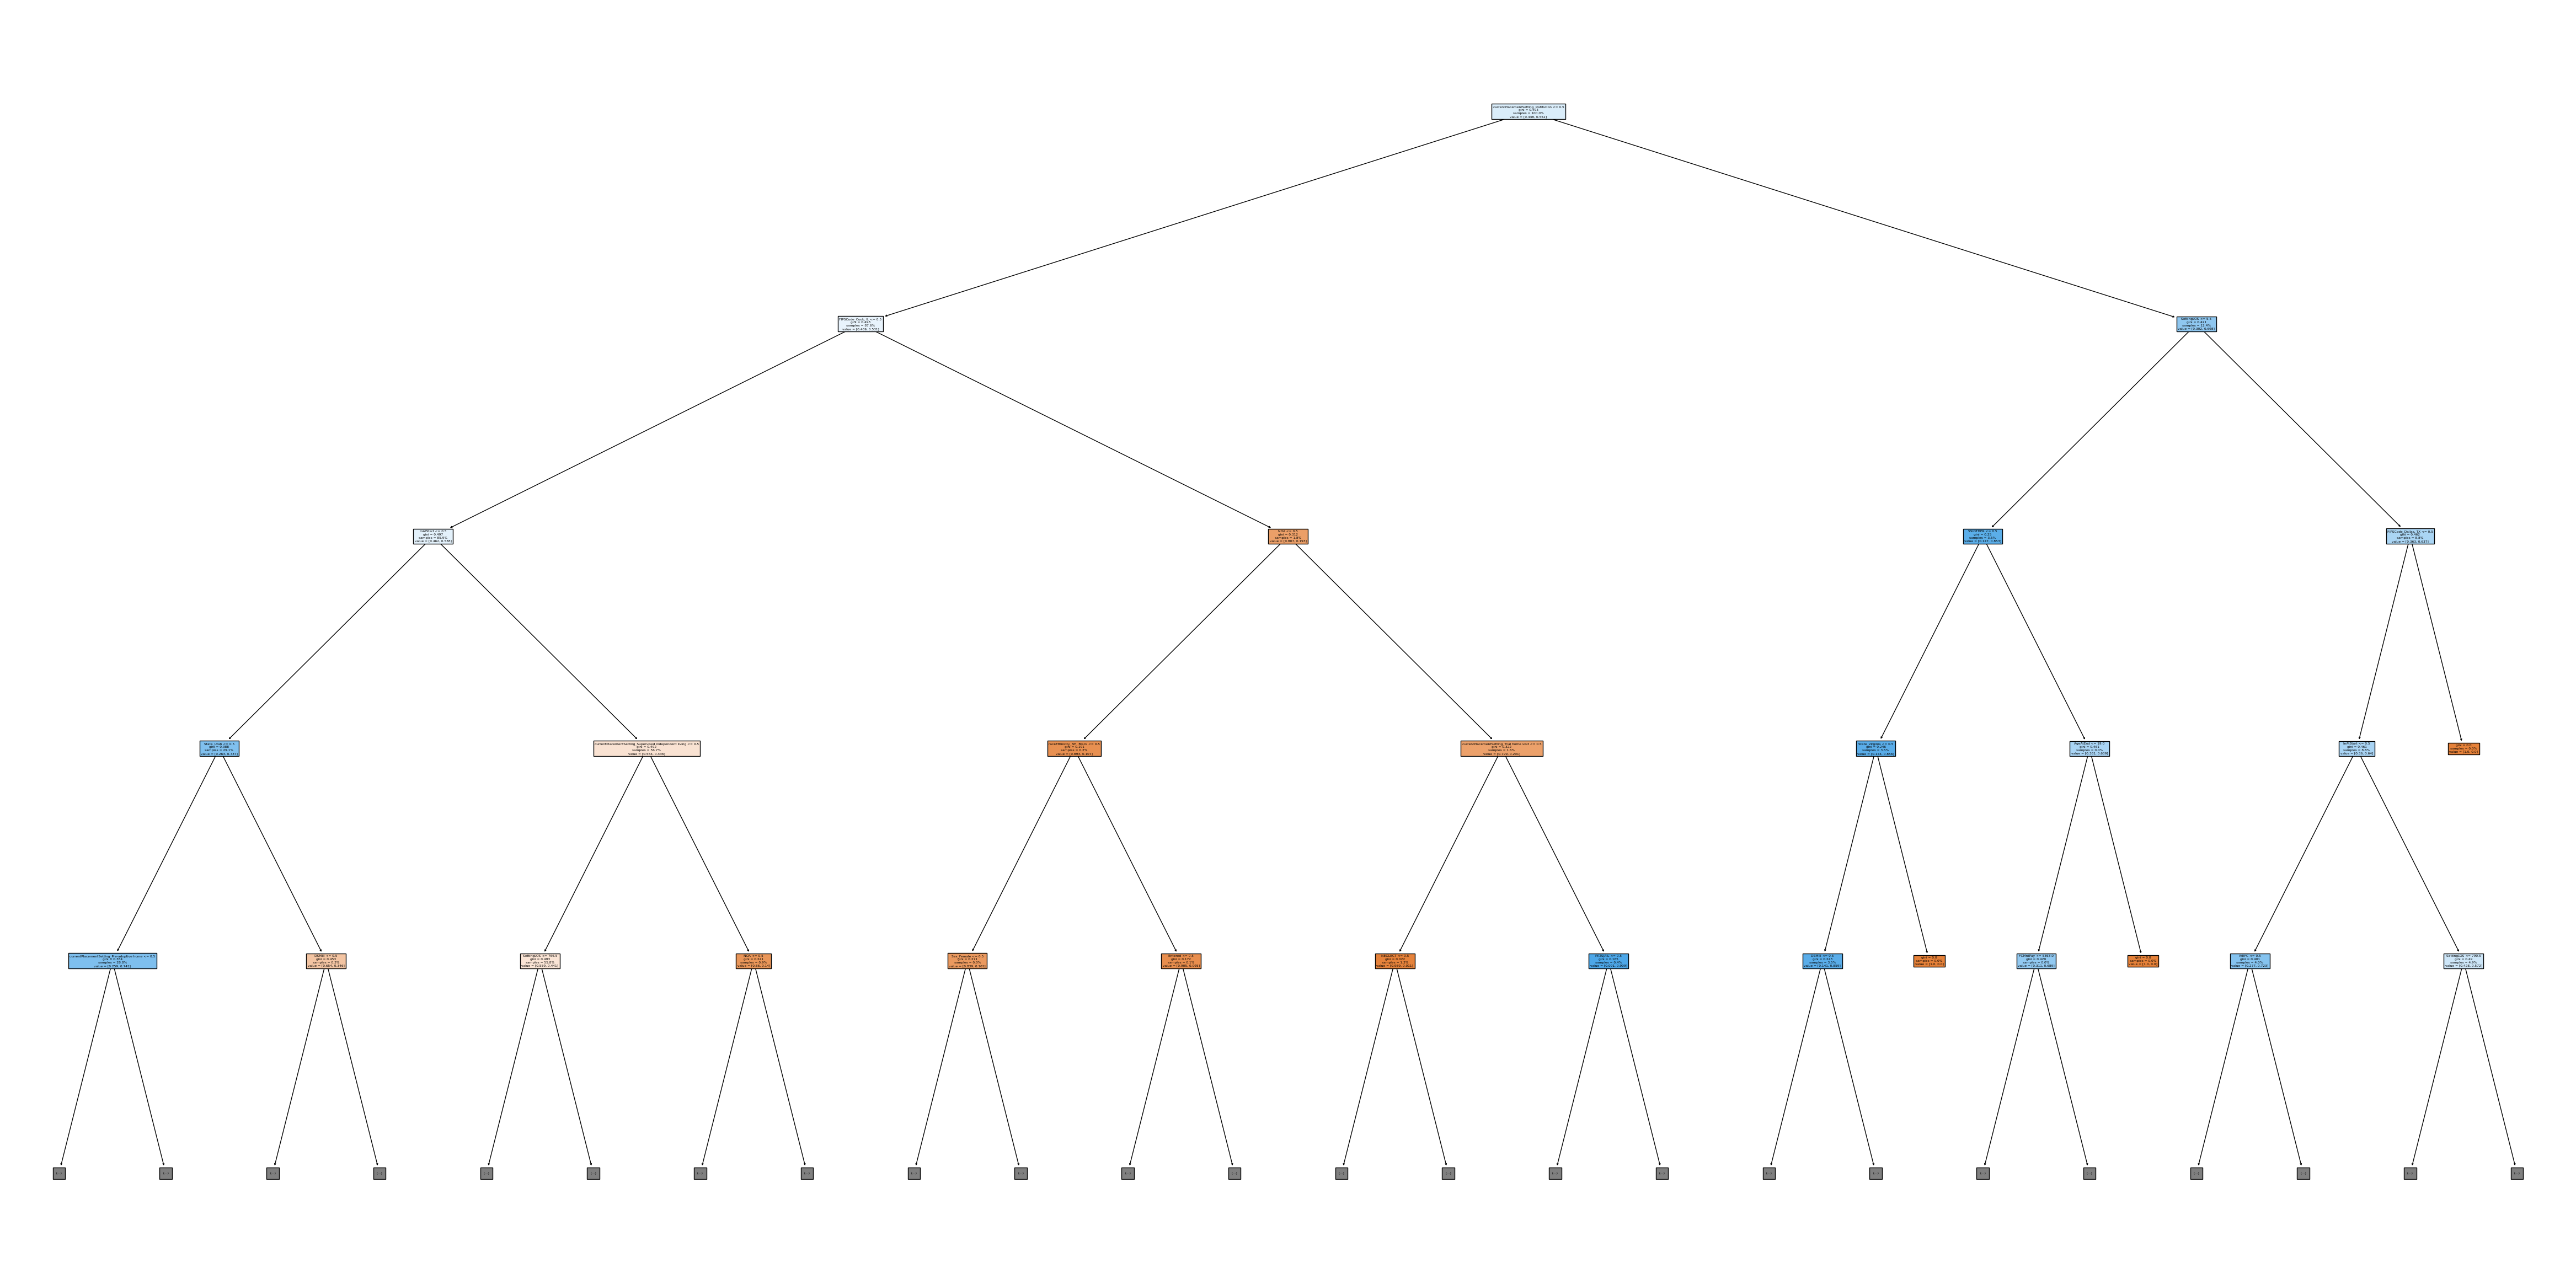

In [28]:
from sklearn.tree import plot_tree

# Pick a single tree from the forest
single_tree = rf.estimators_[0]

plt.figure(figsize=(60,30))
plot_tree(single_tree, filled=True, feature_names=X.columns, max_depth=4, proportion=True)
plt.show()

# XG Boost Model

In [29]:
import xgboost as xgb

# Convert the datasets to DMatrix data structure (optional step for improved performance)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Specify model training parameters
params = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'  # You can change this to 'auc' or other relevant metrics
}

# Train the model
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)

In [30]:
# Making predictions
y_pred_proba = bst.predict(dtest)
y_pred = [1 if x > 0.5 else 0 for x in y_pred_proba]  # Convert probabilities to binary output

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8413855970829535
              precision    recall  f1-score   support

           0       0.87      0.75      0.81     23946
           1       0.82      0.91      0.86     29807

    accuracy                           0.84     53753
   macro avg       0.85      0.83      0.84     53753
weighted avg       0.84      0.84      0.84     53753



In [31]:
# from sklearn.model_selection import GridSearchCV

# xgb_model = xgb.XGBClassifier()
# param_grid = {
#     'max_depth': [3, 4, 5],
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2]
# }

# grid_search = GridSearchCV(xgb_model, param_grid, scoring='accuracy', n_jobs=-1, cv=5)
# grid_search.fit(X_train, y_train)

# # Best parameters and score
# print(grid_search.best_params_)
# print(grid_search.best_score_)

# KNN Model

In [32]:
# KNN Model
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.7147694082190762
              precision    recall  f1-score   support

           0       0.70      0.64      0.67     23946
           1       0.73      0.78      0.75     29807

    accuracy                           0.71     53753
   macro avg       0.71      0.71      0.71     53753
weighted avg       0.71      0.71      0.71     53753



# CNN Model

In [33]:
import tensorflow as tf

In [34]:
age = np.array(X_train['AgeAtEnd'])[10:20]
print("Ages:", age)

age_bins = [0, 5, 10, 15, 20]
age_binned = tf.keras.layers.Discretization(bin_boundaries=age_bins)(age)
print("Age Bins:", age_binned)

age_id = tf.keras.layers.IntegerLookup(vocabulary=np.arange(0, len(age_bins)+1), output_mode='one_hot')(age_binned)
print('Ages as one-hot:', age_id)

Ages: [13.  4. 12. 16.  4. 17. 11. 12.  1. 11.]
Age Bins: tf.Tensor([3 1 3 4 1 4 3 3 1 3], shape=(10,), dtype=int64)
Ages as one-hot: tf.Tensor(
[[0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0]], shape=(10, 7), dtype=int64)


In [35]:
ml_data_df.head()

,MR,VISHEAR,PHYDIS,DSMIII,OTHERMED,TOTALREM,NUMPLEP,PHYABUSE,SEXABUSE,NEGLECT,AAPARENT,DAPARENT,AACHILD,DACHILD,CHILDIS,CHBEHPRB,PRTSDIED,PRTSJAIL,NOCOPE,ABANDMNT,RELINQSH,HOUSING,IVEFC,IVEAA,IVAAFDC,IVDCHSUP,XIXMEDCD,SSIOTHER,NOA,FCMntPay,SettingLOS,PreviousLOS,LifeLOS,AgeAtLatRem,AgeAtEnd,InAtStart,InAtEnd,Entered,Exited,Served,IsWaiting,IsTPR,State,FIPSCode,Sex,AgeAdopt,removalManner,currentPlacementSetting,OutOfStatePlacement,caretakerFamilyStructure,fosterFamilyStructure,raceEthnicity,everAdopted,diagnosedDisability,reunified
3,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,241.0,3077.0,0.0,6727.0,1.0,19.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,Alabama,Fewer than 1000 cases in the County,Female,Unknown,Court ordered,"Foster home, relative",No,Unable to determine,Not applicable,"NH, Black","No, has never been legally adopted",Not yet determined,0
6,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,205.0,5527.0,0.0,7054.0,0.0,19.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,Alabama,Fewer than 1000 cases in the County,Female,Unknown,Court ordered,"Foster home, non-relative",No,Married couple,Not applicable,"NH, Black","No, has never been legally adopted",Not yet determined,0
7,0.0,0.0,0.0,0.0,0.0,1.0,13.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,6788.0,1.0,19.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,Alabama,Fewer than 1000 cases in the County,Male,Unknown,Court ordered,DNG,No,Single female,Not applicable,"NH, Black","No, has never been legally adopted",Not yet determined,0
8,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,6788.0,0.0,18.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,Alabama,Fewer than 1000 cases in the County,Male,Unknown,Court ordered,DNG,No,Single female,Not applicable,"NH, Black","No, has never been legally adopted",Not yet determined,0
9,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,241.0,32.0,0.0,6756.0,0.0,18.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,Alabama,Fewer than 1000 cases in the County,Female,Unknown,Court ordered,"Foster home, non-relative",No,Single female,Married couple,"NH, Black","No, has never been legally adopted",Not yet determined,0


In [36]:
ml_data_df['diagnosedDisability'].value_counts().sort_values()

diagnosedDisability
Not yet determined     32213
DNG                    33063
Yes                    37756
No                    165729
Name: count, dtype: int64

In [123]:
def build_model():
    # Clear session and remove randomness.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Numberical Inputs
    age = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Age')
    # age_bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    # age_binned = tf.keras.layers.Discretization(bin_boundaries=age_bins)(age)
    # age_id = tf.keras.layers.IntegerLookup(
    #     vocabulary=np.arange(0, len(age_bins)+1),
    #     output_mode='one_hot')(age_binned)
    
    total_rem = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='TOTALREM')
    total_rem_bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    total_rem_binned = tf.keras.layers.Discretization(bin_boundaries=total_rem_bins)(total_rem)
    total_rem_id = tf.keras.layers.IntegerLookup(
        vocabulary=np.arange(0, len(total_rem_bins)+1),
        output_mode='one_hot')(total_rem_binned)
    
    num_place = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='NUMPLEP')
    num_place_bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    num_place_binned = tf.keras.layers.Discretization(bin_boundaries=num_place_bins)(num_place)
    num_place_id = tf.keras.layers.IntegerLookup(
        vocabulary=np.arange(0, len(num_place_bins)+1),
        output_mode='one_hot')(num_place_binned)
    
    fcmntPay = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='FCMntPay')
    fcmntPay_bins = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
    fcmntPay_binned = tf.keras.layers.Discretization(bin_boundaries=fcmntPay_bins)(fcmntPay)
    fcmntPay_id = tf.keras.layers.IntegerLookup(
        vocabulary=np.arange(0, len(fcmntPay_bins)+1),
        output_mode='one_hot')(fcmntPay_binned)
    
    settingLOS = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='SettingLOS')
    settingLOS_bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
    settingLOS_binned = tf.keras.layers.Discretization(bin_boundaries=settingLOS_bins)(settingLOS)
    settingLOS_id = tf.keras.layers.IntegerLookup(
        vocabulary=np.arange(0, len(settingLOS_bins)+1),
        output_mode='one_hot')(settingLOS_binned)
    
    previousLOS = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='PreviousLOS')
    previousLOS_bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
    previousLOS_binned = tf.keras.layers.Discretization(bin_boundaries=previousLOS_bins)(previousLOS)
    previousLOS_id = tf.keras.layers.IntegerLookup(
        vocabulary=np.arange(0, len(previousLOS_bins)+1),
        output_mode='one_hot')(previousLOS_binned)
    
    lifeLOS = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='LifeLOS')
    lifeLOS_bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
    lifeLOS_binned = tf.keras.layers.Discretization(bin_boundaries=lifeLOS_bins)(lifeLOS)
    lifeLOS_id = tf.keras.layers.IntegerLookup(
        vocabulary=np.arange(0, len(lifeLOS_bins)+1),
        output_mode='one_hot')(lifeLOS_binned)
    
    ageAtLatRem = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='AgeAtLatRem')
    ageAtLatRem_bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    ageAtLatRem_binned = tf.keras.layers.Discretization(bin_boundaries=ageAtLatRem_bins)(ageAtLatRem)
    ageAtLatRem_id = tf.keras.layers.IntegerLookup(
        vocabulary=np.arange(0, len(ageAtLatRem_bins)+1),
        output_mode='one_hot')(ageAtLatRem_binned)
    
    # Categorical Inputs
    sex = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sex')
    sex_id = tf.keras.layers.StringLookup(
        vocabulary=['Male', 'Female', 'DNG'], output_mode='one_hot')(sex)
    
    state = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='State')
    state_id = tf.keras.layers.StringLookup(
        vocabulary=ml_data_df['State'].unique(), output_mode='one_hot')(state)
    
    removal_manner = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='removalManner')
    removal_manner_id = tf.keras.layers.StringLookup(
        vocabulary=ml_data_df['removalManner'].unique(), output_mode='one_hot')(removal_manner)
    
    current_placement_setting = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='currentPlacementSetting')
    current_placement_setting_id = tf.keras.layers.StringLookup(
        vocabulary=ml_data_df['currentPlacementSetting'].unique(), output_mode='one_hot')(current_placement_setting)
    
    out_of_state_placement = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='OutOfStatePlacement')
    out_of_state_placement_id = tf.keras.layers.StringLookup(
        vocabulary=ml_data_df['OutOfStatePlacement'].unique(), output_mode='one_hot')(out_of_state_placement)
    
    caretaker_family_structure = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='caretakerFamilyStructure')
    caretaker_family_structure_id = tf.keras.layers.StringLookup(
        vocabulary=ml_data_df['caretakerFamilyStructure'].unique(), output_mode='one_hot')(caretaker_family_structure)
    
    foster_family_structure = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='fosterFamilyStructure')
    foster_family_structure_id = tf.keras.layers.StringLookup(
        vocabulary=ml_data_df['fosterFamilyStructure'].unique(), output_mode='one_hot')(foster_family_structure)
    
    ever_adopted = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='everAdopted')
    ever_adopted_id = tf.keras.layers.StringLookup(
        vocabulary=ml_data_df['everAdopted'].unique(), output_mode='one_hot')(ever_adopted)
    
    diagnosed_disability = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='diagnosedDisability')
    diagnosed_disability_id = tf.keras.layers.StringLookup(
        vocabulary=ml_data_df['diagnosedDisability'].unique(), output_mode='one_hot')(diagnosed_disability)
    
    raceEthnicity = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='raceEthnicity')
    raceEthnicity_id = tf.keras.layers.StringLookup(
        vocabulary=ml_data_df['diagnosedDisability'].unique(), output_mode='one_hot')(raceEthnicity)
    
    
    # Binary Inputs
    mr = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='MR')
    vishear = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='VISHEAR')
    phydis = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='PHYDIS')
    dsmiii = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='DSMIII')
    othermed = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='OTHERMED')
    phyabuse = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='PHYABUSE')
    sexabuse = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='SEXABUSE')
    neglect = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='NEGLECT')
    aaparent = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='AAPARENT')
    daparent = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='DAPARENT')
    aachild = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='AACHILD')
    dachild = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='DACHILD')
    childis = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='CHILDIS')
    chbehprb = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='CHBEHPRB')
    prtsdied = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='PRTSDIED')
    prtsjail = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='PRTSJAIL')
    nocope = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='NOCOPE')
    abandmnt = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='ABANDMNT')
    relinquish = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='RELINQSH')
    housing = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='HOUSING')
    ivefc = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='IVEFC')
    iveaa = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='IVEAA')
    ivaafdc = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='IVAAFDC')
    ivdchsup = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='IVDCHSUP')
    xixmedcd = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='XIXMEDCD')
    ssiother = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='SSIOTHER')
    noa = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='NOA')
    istpr = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='IsTPR')
    served = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Served')
    
    features = tf.keras.layers.Concatenate()([sex_id, 
                                              mr, vishear, phydis, dsmiii, othermed, phyabuse, sexabuse, neglect, 
                                              aaparent, daparent, aachild, dachild, childis, chbehprb, prtsdied, prtsjail, nocope, abandmnt, relinquish, housing, 
                                              ivefc, iveaa, ivaafdc, ivdchsup, xixmedcd, ssiother, noa,
                                              istpr, served, state_id, removal_manner_id, current_placement_setting_id, out_of_state_placement_id, caretaker_family_structure_id, foster_family_structure_id, ever_adopted_id, diagnosed_disability_id, raceEthnicity_id,
                                              # numerical columns
                                              age,  # total_rem, num_place, fcmntPay, settingLOS, previousLOS, lifeLOS, ageAtLatRem
                                              # age_id, 
                                              total_rem_id, num_place_id,fcmntPay_id, settingLOS_id, previousLOS_id, lifeLOS_id, ageAtLatRem_id
                                              ])

    dense = tf.keras.layers.Dense(
        units=12, activation='tanh', name='hidden1')(features)
    
    dense = tf.keras.layers.Dense(
        units=12, activation='tanh', name='hidden2')(dense)

    reunified = tf.keras.layers.Dense(
        units=1, activation='sigmoid', name='reunified')(dense)

    model = tf.keras.Model(inputs=[sex, 
                                   mr, vishear, phydis, dsmiii, othermed, phyabuse, sexabuse, neglect,
                                   aaparent, daparent, aachild, dachild, childis, chbehprb, prtsdied, prtsjail, nocope, abandmnt, relinquish, housing,
                                   ivefc, iveaa, ivaafdc, ivdchsup, xixmedcd, ssiother, noa,
                                   istpr, served, state, removal_manner, current_placement_setting, out_of_state_placement, caretaker_family_structure, foster_family_structure, ever_adopted, diagnosed_disability, raceEthnicity,
                                   # numerical columns
                                    age, total_rem, num_place, fcmntPay, settingLOS, previousLOS, lifeLOS, ageAtLatRem
                                   ], 
                           outputs=reunified, 
                           name='Foster')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy'])

    return model

In [124]:
model = build_model()
inputs = {
        'Age': ml_data_df['AgeAtEnd'], 
        'Sex': ml_data_df['Sex'],
        'MR': ml_data_df['MR'],
        'TOTALREM': ml_data_df['TOTALREM'],
        'NUMPLEP': ml_data_df['NUMPLEP'],
        'VISHEAR': ml_data_df['VISHEAR'],
        'PHYDIS': ml_data_df['PHYDIS'],
        'DSMIII': ml_data_df['DSMIII'],
        'OTHERMED': ml_data_df['OTHERMED'],
        'PHYABUSE': ml_data_df['PHYABUSE'],
        'SEXABUSE': ml_data_df['SEXABUSE'],
        'NEGLECT': ml_data_df['NEGLECT'],
        'AAPARENT': ml_data_df['AAPARENT'],
        'DAPARENT': ml_data_df['DAPARENT'],
        'AACHILD': ml_data_df['AACHILD'],
        'DACHILD': ml_data_df['DACHILD'],
        'CHILDIS': ml_data_df['CHILDIS'],
        'CHBEHPRB': ml_data_df['CHBEHPRB'],
        'PRTSDIED': ml_data_df['PRTSDIED'],
        'PRTSJAIL': ml_data_df['PRTSJAIL'],
        'NOCOPE': ml_data_df['NOCOPE'],
        'ABANDMNT': ml_data_df['ABANDMNT'],
        'RELINQSH': ml_data_df['RELINQSH'],
        'HOUSING': ml_data_df['HOUSING'],
        'IVEFC': ml_data_df['IVEFC'],
        'IVEAA': ml_data_df['IVEAA'],
        'IVAAFDC': ml_data_df['IVAAFDC'],
        'IVDCHSUP': ml_data_df['IVDCHSUP'],
        'XIXMEDCD': ml_data_df['XIXMEDCD'],
        'SSIOTHER': ml_data_df['SSIOTHER'],
        'NOA': ml_data_df['NOA'],
        'FCMntPay': ml_data_df['FCMntPay'],
        'SettingLOS': ml_data_df['SettingLOS'],
        'PreviousLOS': ml_data_df['PreviousLOS'],
        'LifeLOS': ml_data_df['LifeLOS'],
        'AgeAtLatRem': ml_data_df['AgeAtLatRem'],
        'IsTPR': ml_data_df['IsTPR'],
        'Served': ml_data_df['Served'],
        'State': ml_data_df['State'],
        'removalManner': ml_data_df['removalManner'],
        'currentPlacementSetting': ml_data_df['currentPlacementSetting'],
        'caretakerFamilyStructure': ml_data_df['caretakerFamilyStructure'],
        'fosterFamilyStructure': ml_data_df['fosterFamilyStructure'],
        'OutOfStatePlacement': ml_data_df['OutOfStatePlacement'],
        'everAdopted': ml_data_df['everAdopted'],
        'diagnosedDisability': ml_data_df['diagnosedDisability'],
        'raceEthnicity': ml_data_df['raceEthnicity']
        }
history = model.fit(
    x = inputs,
    y = ml_data_df['reunified'],
    validation_data=(
        inputs,
        ml_data_df['reunified']),
    epochs=3,
    batch_size=32
)

Epoch 1/3
8399/8399 ━━━━━━━━━━━━━━━━━━━━ 173s 21ms/step - accuracy: 0.7896 - loss: 0.4487 - val_accuracy: 0.8177 - val_loss: 0.3999
Epoch 2/3
8399/8399 ━━━━━━━━━━━━━━━━━━━━ 173s 21ms/step - accuracy: 0.8178 - loss: 0.3991 - val_accuracy: 0.8256 - val_loss: 0.3850
Epoch 3/3
8399/8399 ━━━━━━━━━━━━━━━━━━━━ 173s 21ms/step - accuracy: 0.8235 - loss: 0.3865 - val_accuracy: 0.8283 - val_loss: 0.3785


In [ ]:
print("Accuracy - Age & Sex Only: 0.5622")
print("Accuracy - (Age, sex, All cols to Housing): 0.6351")
print("Accuracy - (Age, sex, All cols to Housing): 0.6624")
print("Accuracy - (Age, sex, All cols not race eth): 0.81")
print("Accuracy with binning: 0.8230")
print("Accuracy without binning: 0.7834")
print("Accuracy with binning except age: 0.8283")

Accuracy - Age & Sex Only: 0.5622
Accuracy - (Age, sex, All cols to Housing): 0.6351
Accuracy - (Age, sex, All cols to Housing): 0.6624
Accuracy - (Age, sex, All cols not race eth): 0.81


# Bias Testing

In [138]:
# Predict for Random Forest Model
rf_y_pred = rf.predict(X_test)

# Convert predictions to a binary outcome
rf_y_pred_binary = (rf_y_pred > 0.5).astype(int)

# Add predictions to your test dataframe
rf_test_df = pd.DataFrame(X_test, columns=X_test.columns)
rf_test_df['Actual'] = y_test
rf_test_df['Predicted'] = rf_y_pred_binary

In [139]:
# Predict for NN Model
nn_y_pred = model.predict(inputs)

# Convert predictions to a binary outcome
nn_y_pred_binary = (nn_y_pred > 0.5).astype(int)

# Add predictions to your test dataframe
nn_test_df = pd.DataFrame(inputs, columns=ml_data_df.columns)
nn_test_df['Actual'] = ml_data_df['reunified']
nn_test_df['Predicted'] = nn_y_pred_binary

8399/8399 ━━━━━━━━━━━━━━━━━━━━ 87s 10ms/step


### Sex - Random Forest

In [140]:
# Calculate accuracy for each group
rf_accuracy_female = rf_test_df[rf_test_df['Sex_Female'] == True]['Actual'] == rf_test_df[rf_test_df['Sex_Female'] == True]['Predicted']
rf_accuracy_male = rf_test_df[rf_test_df['Sex_Male'] == True]['Actual'] == rf_test_df[rf_test_df['Sex_Male'] == True]['Predicted']
rf_accuracy_dng = rf_test_df[rf_test_df['Sex_DNG'] == True]['Actual'] == rf_test_df[rf_test_df['Sex_DNG'] == True]['Predicted']

print(f"Accuracy for Male: {rf_accuracy_male.mean()}")
print(f"Accuracy for Female: {rf_accuracy_female.mean()}")
print(f"Accuracy for DNG: {rf_accuracy_dng.mean()}")

Accuracy for Male: 0.863601837450718
Accuracy for Female: 0.8662542744073463
Accuracy for DNG: 0.6708860759493671


### Sex - Neural Network

In [141]:
# Calculate accuracy for each group
nn_accuracy_female = nn_test_df[nn_test_df['Sex'] == 'Female']['Actual'] == nn_test_df[nn_test_df['Sex'] == 'Female']['Predicted']
nn_accuracy_male = nn_test_df[nn_test_df['Sex'] == 'Male']['Actual'] == nn_test_df[nn_test_df['Sex'] == 'Male']['Predicted']
nn_accuracy_dng = nn_test_df[nn_test_df['Sex'] == 'DNG']['Actual'] == nn_test_df[nn_test_df['Sex'] == 'DNG']['Predicted']

print(f"Accuracy for Male: {nn_accuracy_male.mean()}")
print(f"Accuracy for Female: {nn_accuracy_female.mean()}")
print(f"Accuracy for DNG: {nn_accuracy_dng.mean()}")

Accuracy for Male: 0.8292981382746264
Accuracy for Female: 0.8279392690928511
Accuracy for DNG: 0.6365914786967418


## Plot Sex Bias

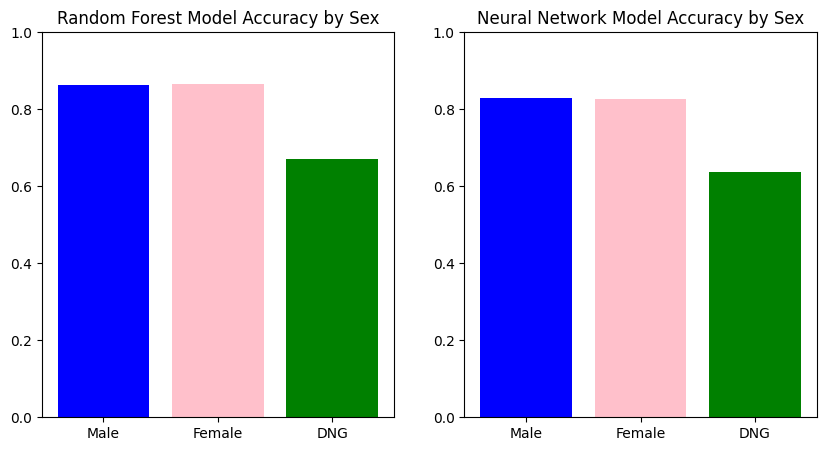

In [142]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

labels = ['Male', 'Female', 'DNG']
colors = ['blue', 'pink', 'green']

# Random Forest
rf_accuracies = [rf_accuracy_male.mean(), rf_accuracy_female.mean(), rf_accuracy_dng.mean()]

axs[0].bar(labels, rf_accuracies, color=colors)
axs[0].set_title('Random Forest Model Accuracy by Sex')
axs[0].set_ylim(0, 1)

# Neural Net
nn_accuracies = [nn_accuracy_male.mean(), nn_accuracy_female.mean(), nn_accuracy_dng.mean()]
axs[1].bar(labels, nn_accuracies, color=colors)
axs[1].set_title('Neural Network Model Accuracy by Sex')
axs[1].set_ylim(0, 1)

# Display the plots
plt.show()

### Race - Random Forest

In [143]:

rf_accuracy_white = rf_test_df[rf_test_df['raceEthnicity_Non-Hispanic (NH), White'] == True]['Actual'] == rf_test_df[rf_test_df['raceEthnicity_Non-Hispanic (NH), White'] == True]['Predicted']
rf_accuracy_black = rf_test_df[rf_test_df['raceEthnicity_NH, Black'] == True]['Actual'] == rf_test_df[rf_test_df['raceEthnicity_NH, Black'] == True]['Predicted']
rf_accuracy_hispanic = rf_test_df[rf_test_df['raceEthnicity_Hispanic (Any Race)'] == True]['Actual'] == rf_test_df[rf_test_df['raceEthnicity_Hispanic (Any Race)'] == True]['Predicted']
rf_accuracy_unknown = rf_test_df[rf_test_df['raceEthnicity_Race/Ethnicity Unknown'] == True]['Actual'] == rf_test_df[rf_test_df['raceEthnicity_Race/Ethnicity Unknown'] == True]['Predicted']
rf_accuracy_native = rf_test_df[rf_test_df['raceEthnicity_NH, Am Ind AK Native'] == True]['Actual'] == rf_test_df[rf_test_df['raceEthnicity_NH, Am Ind AK Native'] == True]['Predicted']
rf_accuracy_more = rf_test_df[rf_test_df['raceEthnicity_NH, More than One Race'] == True]['Actual'] == rf_test_df[rf_test_df['raceEthnicity_NH, More than One Race'] == True]['Predicted']
rf_accuracy_asian = rf_test_df[rf_test_df['raceEthnicity_NH, Asian'] == True]['Actual'] == rf_test_df[rf_test_df['raceEthnicity_NH, Asian'] == True]['Predicted']
rf_accuracy_pacific = rf_test_df[rf_test_df['raceEthnicity_NH, Hawaiian / Other Pac Islander'] == True]['Actual'] == rf_test_df[rf_test_df['raceEthnicity_NH, Hawaiian / Other Pac Islander'] == True]['Predicted']

print(f"Accuracy for Black: {rf_accuracy_black.mean()}")
print(f"Accuracy for White: {rf_accuracy_white.mean()}")
print(f"Accuracy for Hispanic: {rf_accuracy_hispanic.mean()}")
print(f"Accuracy for Unknown: {rf_accuracy_unknown.mean()}")
print(f"Accuracy for Native: {rf_accuracy_native.mean()}")
print(f"Accuracy for More: {rf_accuracy_more.mean()}")
print(f"Accuracy for Asian: {rf_accuracy_asian.mean()}")
print(f"Accuracy for Pacific: {rf_accuracy_pacific.mean()}")

Accuracy for Black: 0.8590016103059581
Accuracy for White: 0.8550712201819118
Accuracy for Hispanic: 0.8903355032548823
Accuracy for Unknown: 0.8908122503328895
Accuracy for Native: 0.825
Accuracy for More: 0.8898163606010017
Accuracy for Asian: 0.9018867924528302
Accuracy for Pacific: 0.8994082840236687


### Race - Neural Network

In [144]:
nn_test_df['raceEthnicity'].value_counts()

raceEthnicity
Non-Hispanic (NH), White             115943
NH, Black                             78472
Hispanic (Any Race)                   39772
Race/Ethnicity Unknown                18635
NH, Am Ind AK Native                   6362
NH, More than One Race                 6000
NH, Asian                              2600
NH, Hawaiian / Other Pac Islander       977
Name: count, dtype: int64

In [145]:
# Calculate accuracy for each group
nn_accuracy_white = nn_test_df[nn_test_df['raceEthnicity'] == 'Non-Hispanic (NH), White']['Actual'] == nn_test_df[nn_test_df['raceEthnicity'] == 'Non-Hispanic (NH), White']['Predicted']
nn_accuracy_black = nn_test_df[nn_test_df['raceEthnicity'] == 'NH, Black']['Actual'] == nn_test_df[nn_test_df['raceEthnicity'] == 'NH, Black']['Predicted']
nn_accuracy_hispanic = nn_test_df[nn_test_df['raceEthnicity'] == 'Hispanic (Any Race)']['Actual'] == nn_test_df[nn_test_df['raceEthnicity'] == 'Hispanic (Any Race)']['Predicted']
nn_accuracy_unknown = nn_test_df[nn_test_df['raceEthnicity'] == 'Race/Ethnicity Unknown']['Actual'] == nn_test_df[nn_test_df['raceEthnicity'] == 'Race/Ethnicity Unknown']['Predicted']
nn_accuracy_native = nn_test_df[nn_test_df['raceEthnicity'] == 'NH, Am Ind AK Native']['Actual'] == nn_test_df[nn_test_df['raceEthnicity'] == 'NH, Am Ind AK Native']['Predicted']
nn_accuracy_more = nn_test_df[nn_test_df['raceEthnicity'] == 'NH, More than One Race']['Actual'] == nn_test_df[nn_test_df['raceEthnicity'] == 'NH, More than One Race']['Predicted']
nn_accuracy_asian = nn_test_df[nn_test_df['raceEthnicity'] == 'NH, Asian']['Actual'] == nn_test_df[nn_test_df['raceEthnicity'] == 'NH, Asian']['Predicted']
nn_accuracy_pacific = nn_test_df[nn_test_df['raceEthnicity'] == 'NH, Hawaiian / Other Pac Islander']['Actual'] == nn_test_df[nn_test_df['raceEthnicity'] == 'NH, Hawaiian / Other Pac Islander']['Predicted']


print(f"Accuracy for Black: {nn_accuracy_black.mean()}")
print(f"Accuracy for White: {nn_accuracy_white.mean()}")
print(f"Accuracy for Hispanic: {nn_accuracy_hispanic.mean()}")
print(f"Accuracy for Unknown: {nn_accuracy_unknown.mean()}")
print(f"Accuracy for Native: {nn_accuracy_native.mean()}")
print(f"Accuracy for More: {nn_accuracy_more.mean()}")
print(f"Accuracy for Asian: {nn_accuracy_asian.mean()}")
print(f"Accuracy for Pacific: {nn_accuracy_pacific.mean()}")

Accuracy for Black: 0.8130161076562341
Accuracy for White: 0.8244137205350905
Accuracy for Hispanic: 0.8550739213517047
Accuracy for Unknown: 0.8638583310973974
Accuracy for Native: 0.7851304621188305
Accuracy for More: 0.8391666666666666
Accuracy for Asian: 0.8780769230769231
Accuracy for Pacific: 0.8444216990788127


## Plot Race Bias

/var/folders/x4/dl28z_rx30n4bp144tvcf38m0000gn/T/ipykernel_60722/139782139.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(labels, rotation=45)
/var/folders/x4/dl28z_rx30n4bp144tvcf38m0000gn/T/ipykernel_60722/139782139.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(labels, rotation=45)


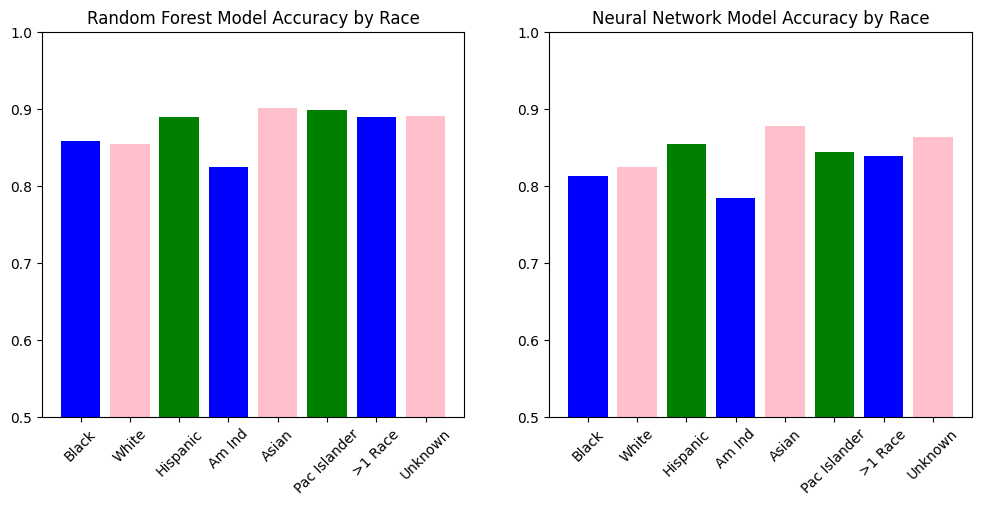

In [146]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5)) 

labels = ['Black', 'White', 'Hispanic', 'Am Ind', 'Asian', 'Pac Islander', '>1 Race', 'Unknown']
# colors = ['blue', 'pink', 'green']

# Random Forest
rf_accuracies = [rf_accuracy_black.mean(), rf_accuracy_white.mean(), rf_accuracy_hispanic.mean(), rf_accuracy_native.mean(), rf_accuracy_asian.mean(), rf_accuracy_pacific.mean(),  rf_accuracy_more.mean(), rf_accuracy_unknown.mean()]

axs[0].bar(labels, rf_accuracies, color=colors)
axs[0].set_title('Random Forest Model Accuracy by Race')
axs[0].set_ylim(.5, 1)
axs[0].set_xticklabels(labels, rotation=45)

# Neural Net
nn_accuracies = [nn_accuracy_black.mean(), nn_accuracy_white.mean(), nn_accuracy_hispanic.mean(), nn_accuracy_native.mean(), nn_accuracy_asian.mean(), nn_accuracy_pacific.mean(), nn_accuracy_more.mean(), nn_accuracy_unknown.mean()]
axs[1].bar(labels, nn_accuracies, color=colors)
axs[1].set_title('Neural Network Model Accuracy by Race')
axs[1].set_ylim(.5, 1)
axs[1].set_xticklabels(labels, rotation=45)

# Display the plots
plt.show()


### Dignosed Disability - Random Forest

In [147]:
rf_accuracy_yes = rf_test_df[rf_test_df['diagnosedDisability_Yes'] == True]['Actual'] == rf_test_df[rf_test_df['diagnosedDisability_Yes'] == True]['Predicted']
rf_accuracy_no = rf_test_df[rf_test_df['diagnosedDisability_No'] == True]['Actual'] == rf_test_df[rf_test_df['diagnosedDisability_No'] == True]['Predicted']
rf_accuracy_dng = rf_test_df[rf_test_df['diagnosedDisability_DNG'] == True]['Actual'] == rf_test_df[rf_test_df['diagnosedDisability_DNG'] == True]['Predicted']
rf_accuracy_nyd = rf_test_df[rf_test_df['diagnosedDisability_Not yet determined'] == True]['Actual'] == rf_test_df[rf_test_df['diagnosedDisability_Not yet determined'] == True]['Predicted']

print(f"Accuracy for No Disability: {rf_accuracy_no.mean()}")
print(f"Accuracy for Disability: {rf_accuracy_yes.mean()}")
print(f"Accuracy for DNG: {rf_accuracy_dng.mean()}")
print(f"Accuracy for Not Yet Determined: {rf_accuracy_nyd.mean()}")

Accuracy for No Disability: 0.8730297196486584
Accuracy for Disability: 0.8670411985018727
Accuracy for DNG: 0.8526584559927907
Accuracy for Not Yet Determined: 0.8302745098039216


### Diagnosed Disability - Neural Network

In [148]:
ml_data_df['diagnosedDisability'].value_counts()

diagnosedDisability
No                    165729
Yes                    37756
DNG                    33063
Not yet determined     32213
Name: count, dtype: int64

In [149]:
nn_accuracy_yes = nn_test_df[nn_test_df['diagnosedDisability'] == 'Yes']['Actual'] == nn_test_df[nn_test_df['diagnosedDisability'] == 'Yes']['Predicted']
nn_accuracy_no = nn_test_df[nn_test_df['diagnosedDisability'] == 'No']['Actual'] == nn_test_df[nn_test_df['diagnosedDisability'] == 'No']['Predicted']
nn_accuracy_dng = nn_test_df[nn_test_df['diagnosedDisability'] == 'DNG']['Actual'] == nn_test_df[nn_test_df['diagnosedDisability'] == 'DNG']['Predicted']
nn_accuracy_nyd = nn_test_df[nn_test_df['diagnosedDisability'] == 'Not yet determined']['Actual'] == nn_test_df[nn_test_df['diagnosedDisability'] == 'Not yet determined']['Predicted']

print(f"Accuracy for No Disability: {nn_accuracy_no.mean()}")
print(f"Accuracy for Disability: {nn_accuracy_yes.mean()}")
print(f"Accuracy for DNG: {nn_accuracy_dng.mean()}")
print(f"Accuracy for Not Yet Determined: {nn_accuracy_nyd.mean()}")

Accuracy for No Disability: 0.8319606103940771
Accuracy for Disability: 0.8442101917576015
Accuracy for DNG: 0.8289326437407374
Accuracy for Not Yet Determined: 0.7905814422748579


## Plot Diagnosed Disability Bias

/var/folders/x4/dl28z_rx30n4bp144tvcf38m0000gn/T/ipykernel_60722/2371518434.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(labels, rotation=45)
/var/folders/x4/dl28z_rx30n4bp144tvcf38m0000gn/T/ipykernel_60722/2371518434.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(labels, rotation=45)


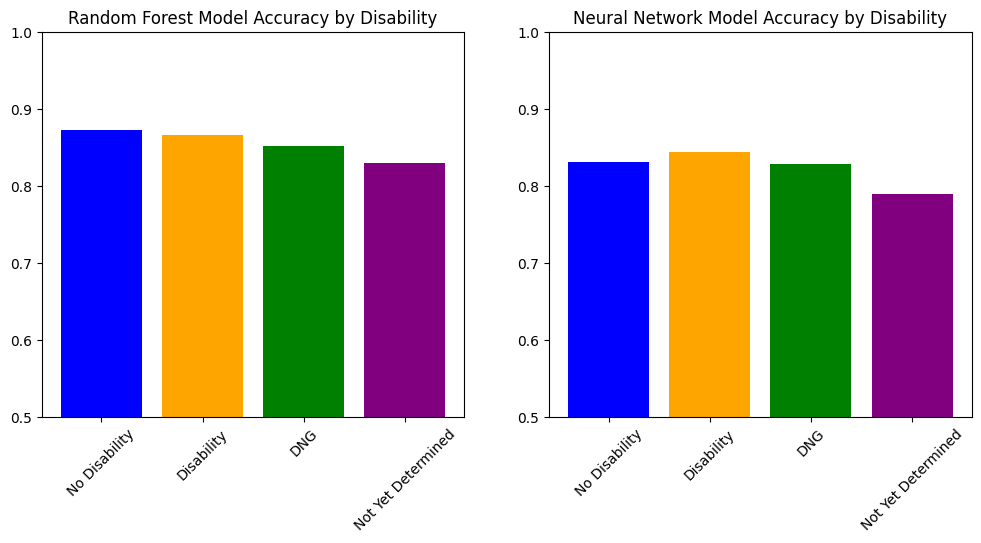

In [150]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5)) 

labels = ['No Disability', 'Disability', 'DNG', 'Not Yet Determined']
colors = ['blue', 'orange', 'green', 'purple']

# Random Forest
rf_accuracies = [rf_accuracy_no.mean(), rf_accuracy_yes.mean(), rf_accuracy_dng.mean(), rf_accuracy_nyd.mean()]

axs[0].bar(labels, rf_accuracies, color=colors)
axs[0].set_title('Random Forest Model Accuracy by Disability')
axs[0].set_ylim(.5, 1)
axs[0].set_xticklabels(labels, rotation=45)

# Neural Net
nn_accuracies = [nn_accuracy_no.mean(), nn_accuracy_yes.mean(), nn_accuracy_dng.mean(), nn_accuracy_nyd.mean()]
axs[1].bar(labels, nn_accuracies, color=colors)
axs[1].set_title('Neural Network Model Accuracy by Disability')
axs[1].set_ylim(.5, 1)
axs[1].set_xticklabels(labels, rotation=45)

# Display the plots
plt.show()


# Dive into the incorrect predictions

# To Do:
- Dive into the incorrect predictions
- Visualize incorrect predictions
- Group by binary Disability/No Disability payment/no payment, etc
- Make sure that df split is correct and in the right location
- check for re-entering the system

In [161]:
ml_data_df

,MR,VISHEAR,PHYDIS,DSMIII,OTHERMED,TOTALREM,NUMPLEP,PHYABUSE,SEXABUSE,NEGLECT,AAPARENT,DAPARENT,AACHILD,DACHILD,CHILDIS,CHBEHPRB,PRTSDIED,PRTSJAIL,NOCOPE,ABANDMNT,RELINQSH,HOUSING,IVEFC,IVEAA,IVAAFDC,IVDCHSUP,XIXMEDCD,SSIOTHER,NOA,FCMntPay,SettingLOS,PreviousLOS,LifeLOS,AgeAtLatRem,AgeAtEnd,InAtStart,InAtEnd,Entered,Exited,Served,IsWaiting,IsTPR,State,FIPSCode,Sex,AgeAdopt,removalManner,currentPlacementSetting,OutOfStatePlacement,caretakerFamilyStructure,fosterFamilyStructure,raceEthnicity,everAdopted,diagnosedDisability,reunified
3,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,241.0,3077.0,0.0,6727.0,1.0,19.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,Alabama,Fewer than 1000 cases in the County,Female,Unknown,Court ordered,"Foster home, relative",No,Unable to determine,Not applicable,"NH, Black","No, has never been legally adopted",Not yet determined,0
6,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,205.0,5527.0,0.0,7054.0,0.0,19.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,Alabama,Fewer than 1000 cases in the County,Female,Unknown,Court ordered,"Foster home, non-relative",No,Married couple,Not applicable,"NH, Black","No, has never been legally adopted",Not yet determined,0
7,0.0,0.0,0.0,0.0,0.0,1.0,13.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,6788.0,1.0,19.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,Alabama,Fewer than 1000 cases in the County,Male,Unknown,Court ordered,DNG,No,Single female,Not applicable,"NH, Black","No, has never been legally adopted",Not yet determined,0
8,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,6788.0,0.0,18.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,Alabama,Fewer than 1000 cases in the County,Male,Unknown,Court ordered,DNG,No,Single female,Not applicable,"NH, Black","No, has never been legally adopted",Not yet determined,0
9,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,241.0,32.0,0.0,6756.0,0.0,18.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,Alabama,Fewer than 1000 cases in the County,Female,Unknown,Court ordered,"Foster home, non-relative",No,Single female,Married couple,"NH, Black","No, has never been legally adopted",Not yet determined,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813223,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,625.0,0.0,625.0,3.0,5.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,Puerto Rico,Fewer than 1000 cases in the County,Male,Not applicable,Court ordered,"Foster home, non-relative",No,Unmarried couple,Single female,Hispanic (Any Race),"No, has never been legally adopted",No,1
813224,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,625.0,0.0,625.0,8.0,10.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,Puerto Rico,Fewer than 1000 cases in the County,Male,Not applicable,Court ordered,"Foster home, non-relative",No,Unmarried couple,Married couple,Hispanic (Any Race),"No, has never been legally adopted",No,1
813233,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,4.0,8.0,8.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,Puerto Rico,Fewer than 1000 cases in the County,Female,Not applicable,Court ordered,"Foster home, non-relative",No,Single female,Single female,Hispanic (Any Race),"No, has never been legally adopted",No,1
813234,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,4.0,12.0,12.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,Puerto Rico,Fewer than 1000 cases in the County,Female,Not a